### Requerimientos

In [1]:
import numpy as np
import heapq
import joblib

from pandas.core.common import random_state
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import arff
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import gc

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")

### Lectura de los datos
#### Input:
  - $file\_path$: Nombre completo con path de la base de datos .arff a cargar

#### Output:
  - $X$: Atributos de entrada numéricos
  - $y$: Salida numérica

In [2]:
import arff
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer


#-------------------------------

# CORRECCIONES IMPORTANTES para wrapped
# cambiar x y a validacion y test -> evaluate de train y validacion para q sea comparable con el votingç#
# separar x  y en training y validacion
# en evaluate en vez de cv -> x_train y x_val y lo mismo para y



def LoadData(file_path):
    # 1. Cargar con liac-arff
    with open(file_path, 'r') as f:
        dataset = arff.load(f)

    col_names = [attr[0] for attr in dataset['attributes']]
    df = pd.DataFrame(dataset['data'], columns=col_names)

    # 2. Limpieza básica
    df.replace([None], np.nan, inplace=True)
    filename = file_path.lower()

    # --- CORRECCIONES ESPECÍFICAS ---

    # CASO US CRIME: Eliminar ID inútil
    if 'crime' in filename and 'communityname' in df.columns:
        df = df.drop(columns=['communityname'])

    # CASO BOSTON: Arreglar columnas que cargan mal
    if 'boston' in filename:
        cols_to_fix = ['CHAS', 'RAD']
        for col in cols_to_fix:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

    # 3. FORZADO NUMÉRICO (SOLO REGRESIÓN)
    # Convertimos a números.
    # En Abalone, 'Sex' se convertirá enteramente en NaNs.
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 4. BORRAR COLUMNAS VACÍAS (EL FIX PARA EL ERROR)
    # Si una columna es 100% NaN (como 'Sex' en Abalone), la borramos YA.
    # Así el imputer no se queja y los tamaños coinciden.
    df.dropna(axis=1, how='all', inplace=True)

    # 5. Imputación de nulos restantes
    # Si quedan huecos sueltos, los rellenamos con la media
    if df.isnull().sum().sum() > 0:
        imputer = SimpleImputer(strategy='mean')
        # Usamos un DataFrame nuevo para evitar conflictos de índices
        data_imputed = imputer.fit_transform(df)
        df = pd.DataFrame(data_imputed, columns=df.columns)

    # 6. Separar X e y
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    return X, y

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $p\_c$: Probabilidad de cruce
- $p\_m$: Probabilidad de mutación
- $random\_state$: Semilla para reproducibilidad
- $X,y$: Datos
- $Phi$: Algoritmos de aprendizaje

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
import os
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, KBinsDiscretizer

# --- 1. PARÁMETROS GENÉTICOS ---
# G pasa a ser el techo real de generaciones; el EA hará early-stopping antes si converge.
MAX_GEN = 250
PACIENCIA = 25
MIN_DELTA = 1e-4

G = MAX_GEN
N = 50
p_c = 0.85
p_m = 0.2

# --- 2. RUTAS ---
DATA_DIR = "../data/regression"
RESULTS_DIR = "../results/regression"
MODELOS_DIR = "../modelos_ajustados"
os.makedirs(RESULTS_DIR, exist_ok=True)

files = {
    #'Boston':    os.path.join(DATA_DIR, 'boston.arff'),
    #'Concrete':  os.path.join(DATA_DIR, 'concrete.arff'),
    'US_Crime':  os.path.join(DATA_DIR, 'us_crime.arff'),
    #'Abalone':   os.path.join(DATA_DIR, 'abalone.arff'),
    #'Elevators': os.path.join(DATA_DIR, 'elevators.arff'),
}


# Nombres de los modelos base (en el mismo orden en que fueron guardados por 00_1_ajuste_modelos)
model_names = ["ET", "RIDGE", "KNN"]

print("✅ Configuración cargada.")
print(f"   Modelos ajustados en: {os.path.abspath(MODELOS_DIR)}")
print(f"   Resultados irán a:    {os.path.abspath(RESULTS_DIR)}")

✅ Configuración cargada.
   Modelos ajustados en: C:\Users\pepeg\PycharmProjects\TFG-EnsembleMultiobjetivo\modelos_ajustados
   Resultados irán a:    C:\Users\pepeg\PycharmProjects\TFG-EnsembleMultiobjetivo\results\regression


### Definición del problema de optimización

$\textit{Minimizar} \ f(\textbf{x}) = RMSE(\textbf{x},D_{train},D_{val},\Phi)$
- $\textbf{x}=(\textbf{matriz})$ es el vector de variables de decisión, donde:
  - $matriz_{i,j}\in\{0,1\}$ indica si para el algoritmos de aprendizaje $i$, el atributos $j$ se ha seleccionado.
  - $vector_i\in\{0,1\}$ indica si el algoritmo de aprendizaje $i$ se ha seleccionado
- $D_{train}=(X_{train},y_{train})$: Conjunto de datos de entrenamiento
- $D_{val}=(X_{val},y_{val})$: Conjunto de datos de validación
- $\Phi$: Algoritmos de aprendizaje


In [4]:
from sklearn.metrics import mean_squared_error


class Problem:
    def __init__(self, X_train, y_train, X_val, y_val, Phi):

        # ------- DATOS --------
        self.X_train = np.asarray(X_train)
        self.y_train = np.asarray(y_train)
        self.X_val   = np.asarray(X_val)
        self.y_val   = np.asarray(y_val)

        # ------- MODELOS --------
        self.Phi = Phi

        # ------- DIMENSIONES -------
        self.n = self.X_train.shape[1]     # nº de atributos
        self.m = len(self.Phi)             # nº modelos base

        # ------- BUFFERS REUTILIZABLES (Optimización de memoria) -------
        self.X_train_selected = np.empty((self.X_train.shape[0], self.n), dtype=self.X_train.dtype)
        self.X_val_selected   = np.empty((self.X_val.shape[0],   self.n), dtype=self.X_val.dtype)
        self.y_val_pred       = np.empty(self.y_val.shape[0], dtype=self.y_val.dtype)

    # =====================================================================================
    #                               FUNCIÓN DE EVALUACIÓN (Fitness)
    # =====================================================================================
    def f(self, matriz, vector):
        """
        Calcula el RMSE del ensemble seleccionado por el individuo.
        """

        # índices de modelos activos
        vector_index = np.flatnonzero(vector)
        n_selected = len(vector_index)

        # 1. PROTECCIÓN: Si no hay modelos seleccionados, devolvemos error infinito
        if n_selected == 0:
            return float('inf')

        self.y_val_pred[:] = 0

        for k, index in enumerate(vector_index):
            # Selección de columnas (Features)
            cols_selected = np.flatnonzero(matriz[:, index])
            p = len(cols_selected)

            # Si el modelo no tiene features seleccionadas, usamos todas (Fallback)
            if p == 0:
                cols_selected = np.arange(self.n)
                p = self.n

            # Copia rápida de datos usando buffers
            X_train_selected = self.X_train_selected[:, :p]
            np.take(self.X_train, cols_selected, axis=1, out=X_train_selected)

            X_val_selected = self.X_val_selected[:, :p]
            np.take(self.X_val, cols_selected, axis=1, out=X_val_selected)

            # 2. IMPORTANTE: Clonar modelo para entrenar desde cero
            model = clone(self.Phi[index])
            model.fit(X_train_selected, self.y_train)
            self.y_val_pred[:] += model.predict(X_val_selected)

        # Promedio de las predicciones (Voting/Stacking simple)
        self.y_val_pred[:] /= n_selected

        rmse = np.sqrt(mean_squared_error(self.y_val, self.y_val_pred))

        return rmse

### Definición de individuo

In [5]:
class Individuo:
    def __init__(self,problem):
        self.matriz = np.zeros((problem.n, problem.m), dtype=int) # selección de atributos para cada algoritmo de aprendizaje
        self.vector = np.zeros(problem.m, dtype=int)  # selección de algoritmos de aprendizaje
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [6]:
def InitializePopulation(P):
    for I in P:
        I.matriz[:] = np.random.randint(0, 2, size=I.matriz.shape)
        I.vector[:] = np.random.randint(0 ,2, size=I.vector.size)

### Función de reparo

In [7]:
def repair(I):

    n = I.matriz.shape[0]
    m = I.matriz.shape[1]

    n_selected = I.vector.sum()

    # --- 1) garantizar >= 2 modelos base ---
    if n_selected == 0:
        idx = np.random.choice(m, 2, replace=False)
        I.vector[:] = 0
        I.vector[idx] = 1

    elif n_selected == 1:
        selected_idx = np.flatnonzero(I.vector)[0]
        rem = np.delete(np.arange(m), selected_idx)
        I.vector[np.random.choice(rem)] = 1

    # índices de modelos base activos
    Phi_index = np.flatnonzero(I.vector)

    # --- 2) garantizar ≥1 atributo por base seleccionada ---
    cols_empty = Phi_index[np.sum(I.matriz[:, Phi_index], axis=0) == 0]
    if len(cols_empty) > 0:
        rand_rows = np.random.randint(0, n, size=len(cols_empty))
        I.matriz[rand_rows, cols_empty] = 1  # in-place


### Función de evaluación

In [8]:
def evaluate(I,problem):
    I.f = problem.f(I.matriz,I.vector)

### Copia de individuo

In [9]:
def copia(I1, I2):
    I1.matriz[:] = I2.matriz
    I1.vector[:] = I2.vector
    I1.f = I2.f

### Selección por torneo binario

In [10]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Cruce
- Cruce uniforme con probabilidad $p\_c$

In [11]:
def crossover(I1,I2,p_c):
    if np.random.random()<=p_c:
        for l in range(I1.vector.size):
            if np.random.random()<=0.5:
                I1.vector[l], I2.vector[l] = I2.vector[l], I1.vector[l]
        for l1 in range(I1.matriz.shape[0]):
            for l2 in range(I1.matriz.shape[1]):
                if np.random.random()<=0.5:
                    I1.matriz[l1][l2], I2.matriz[l1][l2] = I2.matriz[l1][l2], I1.matriz[l1][l2]

### Mutación
- Mutación dinámica (Bäck): $p_m = 1/L$ donde $L$ es el tamaño total del cromosoma
- Si se pasa un valor fijo de $p\_m$ se usa ese; si es `None` se aplica la regla de Bäck

In [12]:
def mutation(I, p_m=None):
    # --- Regla de Bäck: mutación dinámica ---
    # L = total de genes del cromosoma (bits del vector + bits de la matriz)
    # p_m = 1/L garantiza que, en media, se mute exactamente 1 gen por individuo,
    # independientemente del tamaño del problema (clave para datasets de 126 features).
    if p_m is None:
        L = I.vector.size + I.matriz.size
        p_m = 1.0 / max(1, L)

    for l in range(I.vector.size):
        if np.random.random() <= p_m:
            I.vector[l] = np.random.randint(2)
    for l1 in range(I.matriz.shape[0]):
        for l2 in range(I.matriz.shape[1]):
            if np.random.random() <= p_m:
                I.matriz[l1][l2] = np.random.randint(2)

### Progreso del algoritmo

In [13]:
def IniciaProgreso(best_individuo,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final
    progression_bar = tqdm(total=G, leave=False)
    ActualizaProgreso(best_individuo,0,best_outputs,progression_bar)
    return best_outputs,progression_bar

def ActualizaProgreso(best_individuo,gen,best_outputs,progression_bar):
    best_fitness = best_individuo.f
    best_rmse = best_fitness
    progression_bar.set_description("Generation: %s RMSE: %s " % (str(gen), str(best_rmse)))
    best_outputs[gen] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo evolutivo

In [14]:
def EA(G, N, p_c, p_m, X, y, Phi, random_state, paciencia=PACIENCIA, min_delta=MIN_DELTA):
    # Aserciones
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."
    assert 0.0 <= p_c <= 1.0, "La probablidad de cruce debe estar entre 0 y 1."
    assert 0.0 <= p_m <= 1.0, "La probablidad de mutación debe estar entre 0 y 1."

    # ------- SPLIT -------
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=random_state, shuffle=True
    )

    # Problema precomputado y estructuras reutilizables
    problem = Problem(X_train, y_train, X_val, y_val, Phi)

    np.random.seed(random_state)

    # Crear población inicial con N individuos
    P = [Individuo(problem) for _ in range(N)]
    InitializePopulation(P)

    # Reparar y evaluar población inicial
    for I in P:
        repair(I)
        evaluate(I, problem)

    # Crear población auxilar
    Q = [Individuo(problem) for _ in range(2 * N)]

    # Evoluciona durante G generaciones (con early stopping)
    best_ind = min(P)
    best_outputs, progression_bar = IniciaProgreso(best_ind, G)

    best_so_far = best_ind.f
    last_improve_gen = 0

    for gen in range(1, G + 1):
        for i in range(N):
            copia(Q[i], P[i])

        i = N
        while i < 2 * N:
            copia(Q[i], binary_tournament_selection(P))
            copia(Q[i + 1], binary_tournament_selection(P))

            crossover(Q[i], Q[i + 1], p_c)
            # None activa la regla de Bäck: p_m = 1/L calculado por cada individuo
            mutation(Q[i], None)
            mutation(Q[i + 1], None)

            repair(Q[i])
            repair(Q[i + 1])

            evaluate(Q[i], problem)
            evaluate(Q[i + 1], problem)

            i += 2

        R = heapq.nsmallest(N, Q)
        for i in range(N):
            copia(P[i], R[i])

        # actualizar progreso / curvas
        ActualizaProgreso(P[0], gen, best_outputs, progression_bar)

        # --- EARLY STOPPING ---
        current_best = P[0].f
        mejora = best_so_far - current_best

        if mejora > min_delta:
            best_so_far = current_best
            last_improve_gen = gen
        else:
            waited = gen - last_improve_gen

            if waited >= paciencia:
                print(f"🛑 Parada Temprana en Gen {gen} (sin mejora > {min_delta} durante {paciencia} gens)")
                # Rellenar el resto del vector de progreso con el mejor valor para no romper plots
                for g2 in range(gen + 1, G + 1):
                    best_outputs[g2] = best_outputs[gen]
                break

    best_individuo = P[0]
    return best_outputs, best_individuo.f, best_individuo

### Sanity Check

In [15]:
from sklearn.ensemble import VotingRegressor

# --- SANITY CHECK ---
print(f"\n{'='*60}")
print("🔍 SANITY CHECK: Verificando lógica Voting vs Problem")
print(f"{'='*60}")

name_test = list(files.keys())[0]
X_check, y_check = LoadData(files[name_test])


# 2. Cargar los modelos ajustados para ese dataset
ruta_modelos_check = os.path.join(MODELOS_DIR, f"{name_test}_best_models.pkl")
if not os.path.exists(ruta_modelos_check):
    print(f"⚠️ No se encontraron modelos ajustados para '{name_test}' en {ruta_modelos_check}.")
    print("   Ejecuta primero el notebook 00_1_ajuste_modelos.ipynb")
else:
    modelos_dict_check = joblib.load(ruta_modelos_check)
    if isinstance(modelos_dict_check, dict) and "modelos" in modelos_dict_check:
        base_models_check = modelos_dict_check["modelos"]
        model_names_check = list(modelos_dict_check["nombres"])
    else:
        base_models_check = modelos_dict_check
        model_names_check = [f"M{i}" for i in range(len(base_models_check))]
    print(f"   Modelos cargados para '{name_test}': {[type(m).__name__ for m in base_models_check]}")

    indices = np.arange(len(X_check))
    np.random.seed(42)
    np.random.shuffle(indices)
    split = int(len(X_check) * 0.8)
    train_idx, test_idx = indices[:split], indices[split:]
    X_tr_c, X_te_c = X_check[train_idx], X_check[test_idx]
    y_tr_c, y_te_c = y_check[train_idx], y_check[test_idx]

    phi_check = [clone(m) for m in base_models_check]
    n_models  = len(phi_check)
    n_features = X_tr_c.shape[1]

    # VotingRegressor (Baseline)
    vr = VotingRegressor([(f'm{i}', clone(base_models_check[i])) for i in range(n_models)])
    vr.fit(X_tr_c, y_tr_c)
    pred_vr = vr.predict(X_te_c)
    rmse_vr = np.sqrt(mean_squared_error(y_te_c, pred_vr))

    # Problem.f con todos los modelos y todos los features activos
    problem_check = Problem(X_tr_c, y_tr_c, X_te_c, y_te_c, phi_check)
    vector_ones  = np.ones(n_models, dtype=int)
    matriz_ones  = np.ones((n_features, n_models), dtype=int)
    rmse_custom  = problem_check.f(matriz_ones, vector_ones)

    print(f"\nResultados:")
    print(f"   RMSE VotingRegressor: {rmse_vr:.6f}")
    print(f"   RMSE Problem.f:       {rmse_custom:.6f}")

    if abs(rmse_vr - rmse_custom) < 1e-5:
        print("\n✅ ÉXITO: ¡Coinciden!")
    else:
        print(f"\n❌ Diferencia de {abs(rmse_vr - rmse_custom):.6f}. Revisa Problem.f")


🔍 SANITY CHECK: Verificando lógica Voting vs Problem
   Modelos cargados para 'US_Crime': ['LGBMRegressor', 'DecisionTreeRegressor', 'Pipeline']

Resultados:
   RMSE VotingRegressor: 0.142655
   RMSE Problem.f:       0.142655

✅ ÉXITO: ¡Coinciden!


### Correlación entre los modelos elegidos

In [16]:
print(f"\n{'='*60}")
print("📊 DIVERSIDAD: Verificando correlación de predicciones")
print(f"{'='*60}")

preds_dict = {}
rmse_scores = {}

print(f"Entrenando modelos de '{name_test}' en split de prueba...")

for i, m_template in enumerate(base_models_check):
    m = clone(m_template)
    m.fit(X_tr_c, y_tr_c)
    pred = m.predict(X_te_c)
    label = model_names_check[i] if i < len(model_names_check) else f"M{i}"
    preds_dict[label]  = pred
    rmse_scores[label] = np.sqrt(mean_squared_error(y_te_c, pred))

df_preds    = pd.DataFrame(preds_dict)
corr_matrix = df_preds.corr()

print("\n--- 1. Rendimiento Individual (RMSE) ---")
for label, rmse in rmse_scores.items():
    print(f"   {label}: {rmse:.4f}")

print("\n--- 2. Matriz de Correlación (Pearson) ---")
print(corr_matrix)

mask = np.ones(corr_matrix.shape, dtype=bool)
np.fill_diagonal(mask, 0)
mean_corr = corr_matrix.values[mask].mean()
print(f"\n🔹 Correlación Promedio del Pool: {mean_corr:.4f}")

if mean_corr > 0.96:
    print("⚠️ ALERTA: Correlación MUY ALTA (>0.96). Los modelos son casi idénticos.")
elif mean_corr < 0.80:
    print("✅ EXCELENTE: Correlación baja (<0.80). El ensemble funcionará muy bien.")
else:
    print("ℹ️ NORMAL: Correlación moderada (0.80 - 0.96).")
    print("   (En regresión es normal que sea alta porque todos intentan predecir el mismo 'y')")


📊 DIVERSIDAD: Verificando correlación de predicciones
Entrenando modelos de 'US_Crime' en split de prueba...

--- 1. Rendimiento Individual (RMSE) ---
   LightGBM: 0.1410
   DT-Simple: 0.1593
   Ridge: 0.1435

--- 2. Matriz de Correlación (Pearson) ---
           LightGBM  DT-Simple     Ridge
LightGBM   1.000000   0.940931  0.960749
DT-Simple  0.940931   1.000000  0.907013
Ridge      0.960749   0.907013  1.000000

🔹 Correlación Promedio del Pool: 0.9362
ℹ️ NORMAL: Correlación moderada (0.80 - 0.96).
   (En regresión es normal que sea alta porque todos intentan predecir el mismo 'y')


### Detector de Complementariedad


🔍 ANÁLISIS DE COMPLEMENTARIEDAD (ORÁCULO)
   RMSE LightGBM: 0.1410
   RMSE DT-Simple: 0.1593
   RMSE Ridge: 0.1435

🔮 RMSE ORÁCULO: 0.1181
🚀 Margen de Mejora: 16.25%
✅ CONCLUSIÓN: Alta complementariedad.


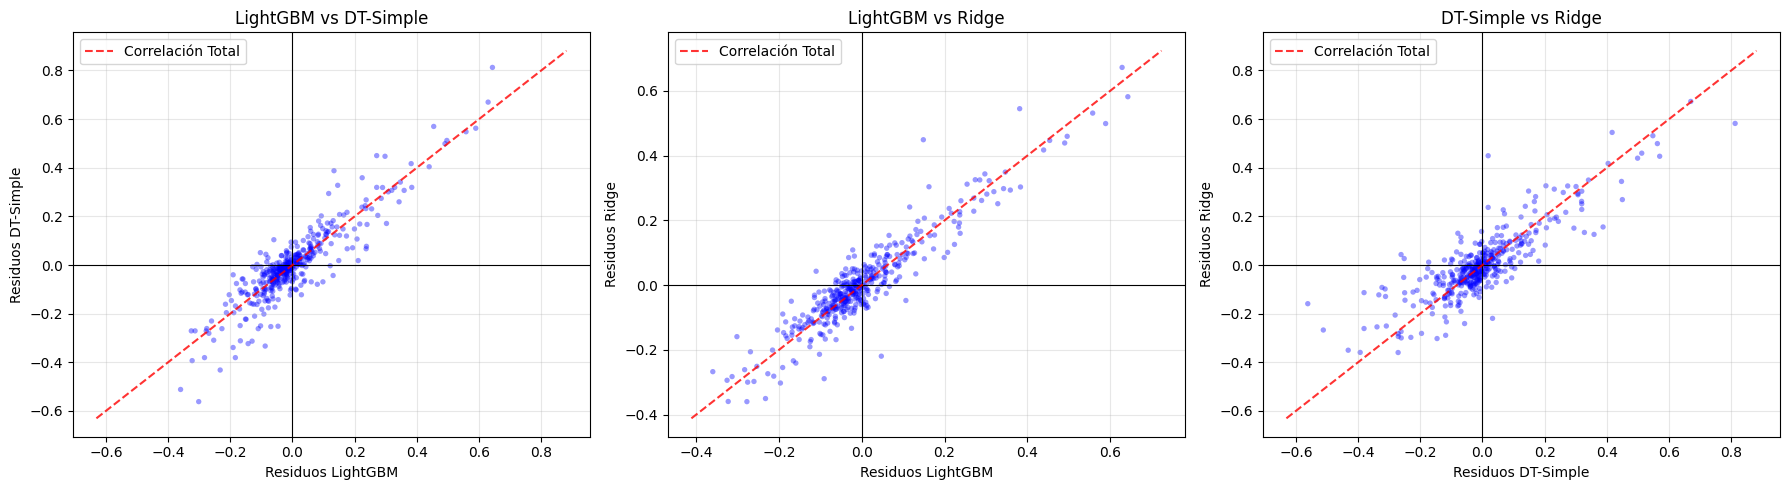

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error

def analizar_complementariedad(y_true, preds_dict):
    """
    Versión mejorada: Calcula el Oráculo y genera gráficos de TODOS los pares de modelos.
    """
    model_names = list(preds_dict.keys())
    n_models = len(model_names)

    # --- 1. CÁLCULO NUMÉRICO (Igual que antes) ---
    squared_errors = np.zeros((len(y_true), n_models))

    print(f"\n{'='*60}")
    print("🔍 ANÁLISIS DE COMPLEMENTARIEDAD (ORÁCULO)")
    print(f"{'='*60}")

    for i, name in enumerate(model_names):
        pred = preds_dict[name]
        squared_errors[:, i] = (y_true - pred) ** 2
        rmse = np.sqrt(np.mean(squared_errors[:, i]))
        print(f"   RMSE {name}: {rmse:.4f}")

    # Oráculo
    min_errors = np.min(squared_errors, axis=1)
    oracle_rmse = np.sqrt(np.mean(min_errors))
    best_single_rmse = np.min(np.sqrt(np.mean(squared_errors, axis=0)))
    mejora_potencial = 100 * (1 - oracle_rmse / best_single_rmse)

    print(f"\n🔮 RMSE ORÁCULO: {oracle_rmse:.4f}")
    print(f"🚀 Margen de Mejora: {mejora_potencial:.2f}%")

    if mejora_potencial < 5.0:
        print("⚠️ CONCLUSIÓN: Poca complementariedad.")
    else:
        print("✅ CONCLUSIÓN: Alta complementariedad.")

    # --- 2. VISUALIZACIÓN DINÁMICA (TODOS CONTRA TODOS) ---
    if n_models >= 2:
        # Generar todas las combinaciones posibles de pares (ej. A-B, A-C, B-C)
        pairs = list(itertools.combinations(model_names, 2))
        n_plots = len(pairs)

        # Crear figura con subgráficos
        fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))
        if n_plots == 1: axes = [axes] # Parche por si solo hay 2 modelos

        for ax, (m1, m2) in zip(axes, pairs):
            # Calcular residuos (errores con signo)
            err1 = y_true - preds_dict[m1]
            err2 = y_true - preds_dict[m2]

            # Scatter plot
            ax.scatter(err1, err2, alpha=0.4, s=15, c='blue', edgecolors='none')

            # Líneas de referencia (cero)
            ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
            ax.axvline(0, color='black', linestyle='-', linewidth=0.8)

            # Línea de "Fallo Idéntico" (Diagonal roja)
            # Si los puntos están en esta línea, los modelos fallan igual (malo)
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()])
            ]
            ax.plot(lims, lims, 'r--', alpha=0.8, label="Correlación Total")

            # Estética
            ax.set_xlabel(f"Residuos {m1}")
            ax.set_ylabel(f"Residuos {m2}")
            ax.set_title(f"{m1} vs {m2}")
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.tight_layout()
        plt.show()

# --- EJECUCIÓN ---
analizar_complementariedad(y_te_c, preds_dict)

### Ejecución del algoritmo evolutivo

In [18]:
import pandas as pd
import time
import os
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.base import clone

best_runs_per_dataset = {}
for name, path in files.items():
    print(f"\n{'='*60}")
    print(f"🔵 PROCESANDO: {name}")
    print(f"{'='*60}")

    if not os.path.exists(path):
        print(f"⚠️ Archivo no encontrado: {path}")
        continue

    # --- CARGAR MODELOS AJUSTADOS PARA ESTE DATASET ---
    ruta_modelos = os.path.join(MODELOS_DIR, f"{name}_best_models.pkl")
    if not os.path.exists(ruta_modelos):
        print(f"⚠️ No se encontraron modelos ajustados para '{name}' en {ruta_modelos}")
        print(f"   Ejecuta primero 00_1_ajuste_modelos.ipynb y vuelve a intentarlo.")
        continue
    modelos_dict = joblib.load(ruta_modelos)
    if isinstance(modelos_dict, dict) and "modelos" in modelos_dict:
        modelos_base = modelos_dict["modelos"]
        model_names = list(modelos_dict["nombres"])
    else:
        modelos_base = modelos_dict
        model_names = [f"M{i}" for i in range(len(modelos_base))]
    print(f"   Modelos cargados: {[type(m).__name__ for m in modelos_base]}")

    X, y = LoadData(path)
    if X is None: continue

    if isinstance(X, pd.DataFrame):
        X = X.values

    dataset_results = []
    min_rmse_dataset = float('inf')
    best_run_data = None

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    print(f"   Iniciando 10-Fold CV...")

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Clonar los modelos ajustados de este dataset para el EA
        Phi = [clone(m) for m in modelos_base]

        # --- A. EVALUAR CADA MODELO BASE POR SEPARADO ---
        fold_baselines = {}
        for m_name, m_template in zip(model_names, modelos_base):
            try:
                m_single = clone(m_template)
                m_single.fit(X_train, y_train)
                pred_single = m_single.predict(X_test)
                rmse_single = np.sqrt(mean_squared_error(y_test, pred_single))
                fold_baselines[f"RMSE_{m_name}"] = rmse_single
            except Exception:
                fold_baselines[f"RMSE_{m_name}"] = float('inf')

        local_best_base = min(fold_baselines.values())

        # --- B. EJECUTAR EA ---
        start_t = time.time()
        best_outputs, best_f, best_solution = EA(
            G, N, p_c, p_m,
            X_train, y_train,
            Phi,
            random_state=42
        )
        elapsed = time.time() - start_t

        # --- C. EVALUAR EN TEST ---
        problem_test = Problem(X_train, y_train, X_test, y_test, Phi)
        test_rmse_ea = problem_test.f(best_solution.matriz, best_solution.vector)

        # Usar los nombres correctos para imprimir resultados
        print_str = f"   F{fold_idx}: EA={test_rmse_ea:.4f}"
        for m_name in model_names:
            val = fold_baselines.get(f'RMSE_{m_name}', 99)
            print_str += f" | {m_name}={val:.4f}"
        print(print_str)

        if test_rmse_ea < min_rmse_dataset:
            min_rmse_dataset = test_rmse_ea
            best_run_data = {
                'fold':      fold_idx,
                'solution':  best_solution,
                'outputs':   best_outputs,
                'f_val':     best_f,
                'modelos_base': modelos_base,   # guardamos los modelos de este dataset
                'model_names': model_names,
                'X_train': X_train, 'y_train': y_train,
                'X_test':  X_test,  'y_test':  y_test
            }

        row_data = {
            'Dataset':       name,
            'Fold':          fold_idx,
            'RMSE_EA_Test':  test_rmse_ea,
            'RMSE_EA_Val':   best_f,
            'RMSE_Best_Base': local_best_base,
            'N_Modelos':     np.sum(best_solution.vector),
            'N_Features':    np.sum(best_solution.matriz),
            'Time_s':        elapsed
        }
        row_data.update(fold_baselines)
        dataset_results.append(row_data)

    # --- FIN BUCLE FOLDS ---
    df_temp = pd.DataFrame(dataset_results)
    means   = df_temp.mean(numeric_only=True)

    # Usar los nombres correctos para la comparativa justa
    mean_bases = [means.get(f'RMSE_{m}', float('inf')) for m in model_names]
    fair_best_base = min(mean_bases)

    summary_row = {
        'Dataset': 'MEDIA', 'Fold': '-',
        'RMSE_EA_Test':  means['RMSE_EA_Test'],
        'RMSE_EA_Val':   means['RMSE_EA_Val'],
        'RMSE_Best_Base': fair_best_base,
        'N_Modelos':     means['N_Modelos'],
        'N_Features':    means['N_Features'],
        'Time_s':        means['Time_s']
    }
    for m, val in zip(model_names, mean_bases):
        summary_row[f'RMSE_{m}'] = val
    df_final = pd.concat([df_temp, pd.DataFrame([summary_row])], ignore_index=True)

    print(f"\n   ⚖️ COMPARATIVA JUSTA ({name}):")
    for m, val in zip(model_names, mean_bases):
        print(f"      {m} (Avg): {val:.4f}")
    print(f"      -----------------------------")
    print(f"      🏆 Mejor Base Global: {fair_best_base:.4f}")
    print(f"      🤖 Tu Sistema (EA):   {means['RMSE_EA_Test']:.4f}")

    if means['RMSE_EA_Test'] < fair_best_base:
        impr = 100 * (1 - means['RMSE_EA_Test'] / fair_best_base)
        print(f"      ✅ RESULTADO: El EA gana por un {impr:.2f}%")
    else:
        diff = 100 * (means['RMSE_EA_Test'] / fair_best_base - 1)
        print(f"      ❌ RESULTADO: El EA pierde por un {diff:.2f}% contra el especialista")

    csv_path = os.path.join(RESULTS_DIR, f"{name}_results.csv")
    df_final.to_csv(csv_path, index=False)
    print(f"   💾 Guardado: {csv_path}")

    if best_run_data:
        best_runs_per_dataset[name] = best_run_data

print(f"\n🚀 ¡Ejecución completa! Revisa la carpeta {RESULTS_DIR}")


🔵 PROCESANDO: US_Crime
   Modelos cargados: ['LGBMRegressor', 'DecisionTreeRegressor', 'Pipeline']
   Iniciando 10-Fold CV...


🛑 Parada Temprana en Gen 131 (sin mejora > 0.0001 durante 25 gens)
   F0: EA=0.1246 | LightGBM=0.1230 | DT-Simple=0.1369 | Ridge=0.1277


🛑 Parada Temprana en Gen 115 (sin mejora > 0.0001 durante 25 gens)
   F1: EA=0.1368 | LightGBM=0.1375 | DT-Simple=0.1470 | Ridge=0.1382


🛑 Parada Temprana en Gen 144 (sin mejora > 0.0001 durante 25 gens)
   F2: EA=0.1225 | LightGBM=0.1207 | DT-Simple=0.1369 | Ridge=0.1241


🛑 Parada Temprana en Gen 144 (sin mejora > 0.0001 durante 25 gens)
   F3: EA=0.1310 | LightGBM=0.1259 | DT-Simple=0.1526 | Ridge=0.1343


🛑 Parada Temprana en Gen 177 (sin mejora > 0.0001 durante 25 gens)
   F4: EA=0.1601 | LightGBM=0.1606 | DT-Simple=0.1815 | Ridge=0.1598


🛑 Parada Temprana en Gen 147 (sin mejora > 0.0001 durante 25 gens)
   F5: EA=0.1547 | LightGBM=0.1532 | DT-Simple=0.1710 | Ridge=0.1524


🛑 Parada Temprana en Gen 146 (sin mejora > 0.0001 durante 25 gens)
   F6: EA=0.1196 | LightGBM=0.1160 | DT-Simple=0.1270 | Ridge=0.1170


🛑 Parada Temprana en Gen 138 (sin mejora > 0.0001 durante 25 gens)
   F7: EA=0.1322 | LightGBM=0.1292 | DT-Simple=0.1468 | Ridge=0.1306


🛑 Parada Temprana en Gen 157 (sin mejora > 0.0001 durante 25 gens)
   F8: EA=0.1423 | LightGBM=0.1408 | DT-Simple=0.1586 | Ridge=0.1419


🛑 Parada Temprana en Gen 149 (sin mejora > 0.0001 durante 25 gens)
   F9: EA=0.1360 | LightGBM=0.1393 | DT-Simple=0.1574 | Ridge=0.1387

   ⚖️ COMPARATIVA JUSTA (US_Crime):
      LightGBM (Avg): 0.1346
      DT-Simple (Avg): 0.1516
      Ridge (Avg): 0.1365
      -----------------------------
      🏆 Mejor Base Global: 0.1346
      🤖 Tu Sistema (EA):   0.1360
      ❌ RESULTADO: El EA pierde por un 1.01% contra el especialista
   💾 Guardado: ../results/regression\US_Crime_results.csv

🚀 ¡Ejecución completa! Revisa la carpeta ../results/regression


### Imprimir los algoritmos de aprendizaje seleccionados, los atributos seleccionados para cada algoritmo de aprendizaje y el fitness (rmse en un conjunto de validación interno)

In [ ]:
def PrintSolution(I, Phi):
    Phi_index = np.where(I.vector == 1)[0]
    for index in Phi_index:
        attributes_selected = [l for l in range(I.matriz.shape[0]) if I.matriz[l,index] == 1]
        print(f"   🤖 Modelo: {Phi[index]}")
        print(f"      Atributos: {attributes_selected}")

### Visualización de la evolución del algoritmo

In [ ]:
def VisualizaEvolucion(best_outputs, title):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_title(f"Evolución - {title}")
    plt.plot(best_outputs)
    plt.xlabel("Generación")
    plt.ylabel("Fitness (RMSE Val)")
    plt.grid(True, alpha=0.3)
    plt.show()

### Resultados en el conjunto de test

In [ ]:
from sklearn.base import clone

for name, data in best_runs_per_dataset.items():
    print(f"\n{'#'*80}")
    print(f"📊 REPORTE VISUAL PARA: {name.upper()}")
    print(f"   (Mejor Fold encontrado: {data['fold']})")
    print(f"{'#'*80}\n")

    best_solution = data['solution']
    best_outputs  = data['outputs']
    best_f        = data['f_val']
    modelos_base  = data['modelos_base']   # modelos ajustados específicos del dataset
    model_names   = data.get('model_names', [f"M{i}" for i in range(len(modelos_base))])
    X_train, y_train = data['X_train'], data['y_train']
    X_test,  y_test  = data['X_test'], data['y_test']

    print("--- 🧬 Estructura del Mejor Individuo (Ensemble) ---")
    PrintSolution(best_solution, model_names)
    print(f"\n📉 RMSE Validación Interna (Fitness): {best_f:.4f}")

    VisualizaEvolucion(best_outputs, title=f"{name} (Fold {data['fold']})")

    # Clonar los modelos ajustados de este dataset para evaluar en test
    Phi_test     = [clone(m) for m in modelos_base]
    problem_test = Problem(X_train, y_train, X_test, y_test, Phi_test)
    rmse_test    = problem_test.f(best_solution.matriz, best_solution.vector)

    print(f"🏁 RMSE TEST FINAL ({name}): {rmse_test:.4f}")
    print("-" * 80)
